# Regressions and Linear Models in Python

In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


## Set up data

In [2]:
# Read in data
train = pd.read_csv("TrainingSet2.csv")
validate = pd.read_csv("ValidationSet2.csv")

In [3]:
# Drop entity condition variables
to_drop = ["Unnamed: 0", "entity_condition_1", "entity_condition_2", "entity_condition_3", "entity_condition_4"]
train.drop(to_drop, axis=1, inplace=True)
validate.drop(to_drop, axis=1, inplace=True)

In [4]:
train.head()

,education,sex,age,pod,marital_status,race,hispanic,A41,C15,C16,...,R06,R09,R53,R54,R56,R57,R62,R64,R68,R99
0,high school,F,91,Home,W,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,high school,M,82,Home,M,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,high school,F,89,Home,W,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Bachelor,F,84,Nursing Home,M,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,high school,F,84,Nursing Home,M,White,Non-Hispanic,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Make the dummies
train = pd.concat([pd.get_dummies(train["education"]), train.drop("education", axis=1)], axis=1)
train = pd.concat([pd.get_dummies(train["marital_status"]), train.drop("marital_status", axis=1)], axis=1)
train = pd.concat([pd.get_dummies(train["race"]), train.drop("race", axis=1)], axis=1)
train = pd.concat([pd.get_dummies(train["hispanic"]), train.drop("hispanic", axis=1)], axis=1)
train["sex"].replace("M", 0, inplace=True)
train["sex"].replace("F", 1, inplace=True)

validate = pd.concat([pd.get_dummies(validate["education"]), validate.drop("education", axis=1)], axis=1)
validate = pd.concat([pd.get_dummies(validate["marital_status"]), validate.drop("marital_status", axis=1)], axis=1)
validate = pd.concat([pd.get_dummies(validate["race"]), validate.drop("race", axis=1)], axis=1)
validate = pd.concat([pd.get_dummies(validate["hispanic"]), validate.drop("hispanic", axis=1)], axis=1)
validate["sex"].replace("M", 0, inplace=True)
validate["sex"].replace("F", 1, inplace=True)

In [5]:
train = train.drop("pod", axis=1)
validate = validate.drop("pod", axis=1)

In [7]:
train.head()

,C./S. American,Cuban,Mexican,Non-Hispanic,Other Hispanic,Puerto Rican,Japanese,American Indian,Asian Indian,Black,...,R06,R09,R53,R54,R56,R57,R62,R64,R68,R99
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Now add in the interaction terms

Column 33 is the first diease column, then all the way to the end. Column 32 is age. Column 19 starts marital status, 22 ends marital status

In [6]:
# Columns we want to interact
relationship = pd.concat([train[train.columns[19:23]],train['sex']],axis=1)
relationship_cols = list(relationship)
disease_cols = list(train.columns[33:]) 

In [7]:
# Make the interaction terms
i = 1
for rcol in relationship_cols:
    for dcol in disease_cols:
        name = "Feat_" + str(i)
        train[name] = train[rcol]*train[dcol]
        validate[name] = validate[rcol]*validate[dcol]
        i += 1
        if i%50 == 0:
            print ("tranforming feature:", i)

('tranforming feature:', 50)
('tranforming feature:', 100)
('tranforming feature:', 150)
('tranforming feature:', 200)
('tranforming feature:', 250)
('tranforming feature:', 300)
('tranforming feature:', 350)
('tranforming feature:', 400)
('tranforming feature:', 450)
('tranforming feature:', 500)


## Lasso Model

In [8]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

In [9]:
# Scale the data (trainig)
scaler = StandardScaler()
scaler.fit(train.drop("age", axis=1))
sdat = scaler.transform(train.drop("age", axis=1))

In [10]:
# Scale the validation set
scaler = StandardScaler()
scaler.fit(validate.drop("age", axis=1))
vdat = scaler.transform(validate.drop("age", axis=1))

In [11]:
VTruth = validate["age"]

In [12]:
n = train.shape[0]

Now we can cross validate on the tuning parameter:

In [13]:
errors = []
min_error = np.Inf
best_alpha = 0
#alphas = [.01, .03, .05, .07, .09, .1, .5, 1, 1.5, 2, 3, 4, 6, 9, 10, 15, 20, 25, 30, 50, 70, 100]
alphas = [.006,.008, .009, .01, .013, .015, .017, .02]
for a in alphas:
    print ("Fitting with alpha =", a)
    # fit the lasso
    l1 = linear_model.Lasso(alpha=a)
    l1.fit(sdat[1:int(n/4)], train["age"][1:int(n/4)])
    
    predictions = l1.predict(vdat)
    error = np.mean((predictions - VTruth)**2)
    errors.append(error)
    
    if error < min_error:
        best_alpha = a
        min_error = error
        
print ("Best alpha is:", best_alpha)

Fitting with alpha = 0.006
Fitting with alpha = 0.008
Fitting with alpha = 0.009
Fitting with alpha = 0.01
Fitting with alpha = 0.013
Fitting with alpha = 0.015
Fitting with alpha = 0.017
Fitting with alpha = 0.02
Best alpha is: 0.01


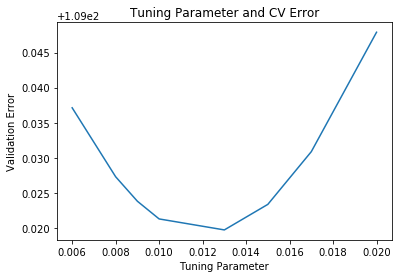

In [17]:
plt.plot(alphas, errors)
plt.xlabel("Tuning Parameter")
plt.ylabel("Validation Error")
plt.title("Tuning Parameter and CV Error")
plt.savefig("Lasso_CV.png")

I am getting that the optimal tuning parameter is 0.013!!

### Set up test set

In [13]:
# Read in data
test = pd.read_csv("TestSet2.csv")

In [14]:
test.drop(to_drop, axis=1, inplace=True)

In [15]:
# Make the dummies
test = pd.concat([pd.get_dummies(test["education"]), test.drop("education", axis=1)], axis=1)
test = pd.concat([pd.get_dummies(test["marital_status"]), test.drop("marital_status", axis=1)], axis=1)
test = pd.concat([pd.get_dummies(test["race"]), test.drop("race", axis=1)], axis=1)
test = pd.concat([pd.get_dummies(test["hispanic"]), test.drop("hispanic", axis=1)], axis=1)
test["sex"].replace("M", 0, inplace=True)
test["sex"].replace("F", 1, inplace=True)

In [16]:
test = test.drop("pod", axis=1)

In [17]:
# Make the interaction terms
i = 1
for rcol in relationship_cols:
    for dcol in disease_cols:
        name = "Feat_" + str(i)
        test[name] = test[rcol]*test[dcol]
        i += 1
        if i%50 == 0:
            print ("tranforming feature:", i)

('tranforming feature:', 50)
('tranforming feature:', 100)
('tranforming feature:', 150)
('tranforming feature:', 200)
('tranforming feature:', 250)
('tranforming feature:', 300)
('tranforming feature:', 350)
('tranforming feature:', 400)
('tranforming feature:', 450)
('tranforming feature:', 500)


In [18]:
# Scale the data (test)
scaler = StandardScaler()
scaler.fit(test.drop("age", axis=1))
tdat = scaler.transform(test.drop("age", axis=1))

## Fit Final Lasso Model
#### $\alpha = 0.013$

In [25]:
# Fit the model
l1 = linear_model.Lasso(alpha=0.013)
l1.fit(sdat, train["age"])

Lasso(alpha=0.013, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [26]:
# Get the predictions
predictions = l1.predict(tdat)

In [28]:
# Error metrics
truth = test["age"]
errors = (predictions-truth)
mse_lasso = np.mean( (errors)**2 )
mae_lasso = np.mean( np.abs(errors) )
lasso_25 = np.percentile( errors, 25)
lasso_75 = np.percentile( errors, 75)
print ("MSE:", mse_lasso)
print ("MAE:", mae_lasso)
print ("25th percentile of errors:", lasso_25)
print ("75th percentile of errors:", lasso_75)

MSE: 113.5478612390914
MAE: 8.198234388160284
25th percentile of errors: -6.28006270992
75th percentile of errors: 6.88364004854


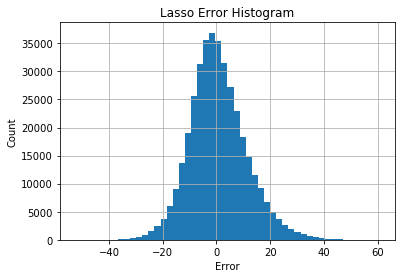

In [29]:
# Error histogram
plt.hist(errors, bins=50)
plt.title("Lasso Error Histogram")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid()
#plt.savefig("lasso_errors.png")
plt.show()

In [30]:
# Take a look at the most important coefficients
coeffs = l1.coef_

In [32]:
# Figure out how many are zero
print ("Forced", (coeffs == 0).sum(), "coefficients to zero of", len(coeffs))

Forced 172 coefficients to zero of 547


In [33]:
# get better names for coeffs
good_names = []
for rcol in relationship_cols:
    for dcol in disease_cols:
        name = str(rcol) + "_" + str(dcol)
        good_names.append(name)
        
col_names = list(train.columns)[0:len(coeffs) - len(good_names)+1] + good_names 

In [55]:
# tie them together, then sort
coeff_tuples = []
for i in range(len(col_names)-1):
    coeff_tuples.append( (col_names[i], coeffs[i]))
# sort it
coeff_tuples = sorted(coeff_tuples, key=lambda x:x[1], reverse=True)
coeff_tuples

[('W', 5.7559865249562616),
 ('<8th grade', 1.0641239256425172),
 ('S_F01', 0.77885121055301287),
 ('White', 0.75389418046003231),
 ('S_G20', 0.72895015507295213),
 ('F01', 0.71661535396047815),
 ('M_G20', 0.68513392087945146),
 ('G20', 0.65834910174635086),
 ('I49', 0.63909572508972246),
 ('D_G20', 0.62359635390475132),
 ('M_F01', 0.59959342749255418),
 ('D_F01', 0.58579819837347569),
 ('R53', 0.49650084821945084),
 ('M_I49', 0.48674913515052914),
 (' Japanese', 0.45934426329847167),
 ('Doctorate/professional', 0.4475101736520285),
 ('Non-Hispanic', 0.40510422826417941),
 ('sex', 0.39651989269377819),
 ('M_G12', 0.34293346198655716),
 ('M_I47', 0.33451748626672273),
 ('S_I49', 0.33057256643422783),
 ('M_C56', 0.31791391162886834),
 ('J15', 0.31048282058350452),
 ('Masters', 0.30997400500393235),
 ('S_I47', 0.29980330870403965),
 ('S_J43', 0.27927645284895858),
 ('Cuban', 0.27613072573543673),
 ('Chinese', 0.26812078399680717),
 ('R57', 0.26288516710988202),
 ('Bachelor', 0.26181729457

In [19]:
errors = []
min_error = np.Inf
best_alpha = 0
alphas = [1, 10, 50, 100, 500, 1000, 1500, 2000, 3000, 5000, ]
#alphas = [1, 1.5, 2, 3, 6, 9, 10, 15, 20, 25, 30, 50, 80, 100, 500]
#alphas = [.006,.008, .009, .01, .013, .015, .017, .02]
for a in alphas:
    print ("Fitting with alpha =", a)
    # fit the ridge
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(sdat[1:int(n/4)], train["age"][1:int(n/4)])
    
    predictions = ridge.predict(vdat)
    error = np.mean((predictions - VTruth)**2)
    errors.append(error)
    
    if error < min_error:
        best_alpha = a
        min_error = error
        
print ("Best alpha is:", best_alpha)

('Fitting with alpha =', 1)
('Fitting with alpha =', 10)
('Fitting with alpha =', 50)
('Fitting with alpha =', 100)
('Fitting with alpha =', 500)
('Fitting with alpha =', 1000)
('Fitting with alpha =', 1500)
('Fitting with alpha =', 2000)
('Fitting with alpha =', 3000)
('Fitting with alpha =', 5000)
('Best alpha is:', 2000)


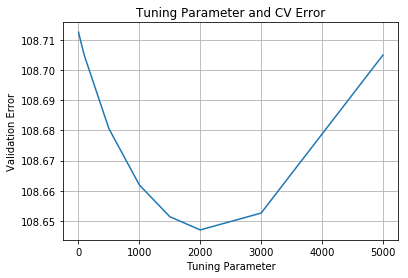

In [20]:
plt.plot(alphas, errors)
plt.xlabel("Tuning Parameter")
plt.ylabel("Validation Error")
plt.title("Tuning Parameter and CV Error")
plt.grid()
plt.savefig("Ridge_CV.png")
plt.show()

In [22]:
ridge = linear_model.Ridge(alpha=2000)
ridge.fit(sdat, train["age"])
predictions = ridge.predict(tdat)

In [23]:
# Error metrics
mse_ridge = np.mean( (predictions-test["age"])**2 )
mae_ridge = np.mean( np.abs(predictions-test["age"]) )
ridge_25 = np.percentile( (predictions-test["age"]), 25)
ridge_75 = np.percentile( (predictions-test["age"]), 75)
print ("MSE:", mse_ridge)
print ("MAE:", mae_ridge)
print ("25th percentile of errors:", ridge_25)
print ("75th percentile of errors:", ridge_75)

MSE: 113.10074057984193
MAE: 8.180315451170774
25th percentile of errors: -6.26372086203
75th percentile of errors: 6.87294844215


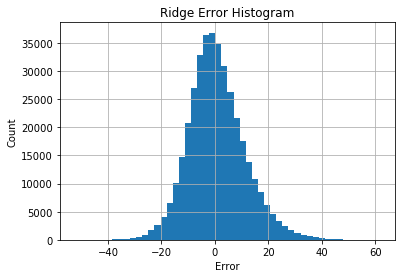

In [24]:
# Error histogram
plt.hist((predictions-test["age"]), bins=50)
plt.title("Ridge Error Histogram")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid()
plt.show()

In [25]:
ridge.coef_

array([ -9.24929208e-02,   2.82585338e-01,  -5.77089924e-01,
         3.99413848e-01,  -7.70348326e-04,  -1.67340264e-01,
         4.37871043e-01,  -1.91674243e-01,  -1.56239085e-01,
        -7.18539599e-01,   2.44194650e-01,  -2.96039950e-02,
        -2.61704525e-02,  -6.15996698e-02,   3.83759939e-02,
        -2.87246509e-01,  -1.54062170e-01,  -3.45257805e-02,
         6.09971827e-01,  -2.02744385e+00,  -1.08786617e+00,
        -3.47906003e+00,   4.59142674e+00,  -3.26020149e-01,
         9.18320901e-01,  -3.89186999e-01,   1.29155428e-01,
         3.96083460e-01,   2.24660254e-01,  -2.37205740e-01,
        -3.77675657e-01,   7.86826335e-01,  -1.36839777e-01,
        -1.73163019e-01,  -1.33295395e-01,  -1.72406373e-01,
        -1.25804166e-01,  -1.75030120e-01,  -2.16249857e-01,
        -4.83476089e-02,  -2.58492327e-01,  -1.12157268e-01,
         2.44896077e-02,  -1.74377210e-01,  -1.42715488e-02,
        -2.17720510e-01,  -8.37628295e-02,  -1.01551663e-01,
        -1.84974695e-01,

In [26]:
# get better names for coeffs
good_names = []
for rcol in relationship_cols:
    for dcol in disease_cols:
        name = str(rcol) + "_" + str(dcol)
        good_names.append(name)
        
col_names = list(train.columns)[0:len(ridge.coef_) - len(good_names)+1] + good_names 

In [27]:
# tie them together, then sort
coeff_tuples = []
for i in range(len(col_names)-1):
    coeff_tuples.append( (col_names[i], ridge.coef_[i]))
# sort it
coeff_tuples = sorted(coeff_tuples, key=lambda x:x[1], reverse=True)
coeff_tuples

[('W', 4.5914267375114974),
 ('<8th grade', 0.91832090120319998),
 ('S_F01', 0.78775953701838908),
 ('sex', 0.78682633472876284),
 ('S_G20', 0.75019844465523911),
 ('G20', 0.72711831194457488),
 ('M_G20', 0.6653734519315605),
 ('F01', 0.66363596261747815),
 ('D_G20', 0.64579691477414869),
 ('White', 0.60997182719417498),
 ('M_F01', 0.60216544619920664),
 ('D_F01', 0.59320107803280764),
 ('I49', 0.55353827040018222),
 ('M_I49', 0.5332027683381324),
 (' Japanese', 0.43787104340452837),
 ('Non-Hispanic', 0.39941384760477266),
 ('Doctorate/professional', 0.39608345963016284),
 ('S_I49', 0.36928307502777252),
 ('R53', 0.3573701579474205),
 ('S_J43', 0.31684947785301276),
 ('M_I47', 0.31284692369799832),
 ('D_I49', 0.30562504158103682),
 ('S_I47', 0.29197999476636838),
 ('S_R53', 0.2903260314200205),
 ('Cuban', 0.28258533787111378),
 ('I47', 0.27854862297255689),
 ('M_R53', 0.27166210257490231),
 ('J15', 0.27080848223414006),
 ('C56', 0.25009412225945721),
 ('Chinese', 0.24419464989077752),


In [31]:
regr = linear_model.LinearRegression()
regr.fit((train.drop("age", axis=1))[1:int(n/4)], train["age"][1:int(n/4)])
predictions=regr.predict(test.drop("age", axis=1))
#print(np.mean( (validate["age"]-regr.predict(validate.drop("age", axis=1)))**2 ))
#print(np.mean( (test["age"]-regr.predict(test.drop("age", axis=1)))**2 ))
#regr.coef_

In [29]:
regr = linear_model.LinearRegression()
regr.fit(sdat[1:int(n/4)], train["age"][1:int(n/4)])
print(np.mean( (validate["age"]-regr.predict(vdat))**2 ))
print(np.mean( (test["age"]-regr.predict(tdat))**2 ))
regr.coef_

1.7938592821353614e+25
1.735121556845307e+25


array([  9.34841844e+10,   1.12605006e+11,   1.99809246e+11,
         2.68996923e+11,   8.11434692e+10,   9.10993130e+10,
         3.95604509e+11,   3.44439664e+11,   2.86170443e+11,
         1.59749960e+12,   4.54098894e+11,   4.41041029e+11,
         6.26450613e+10,   9.84450671e+10,   2.68744341e+11,
         3.67395949e+11,   9.02737006e+10,   2.64111381e+11,
         1.82548129e+12,  -5.12810957e+11,  -6.95039071e+11,
        -4.01602583e+11,  -6.95427498e+11,   2.23313675e+12,
         2.35866400e+12,   1.82694459e+12,   2.38583250e+12,
         1.08180364e+12,   1.59842674e+12,   3.71816261e+12,
         2.49076411e+12,   8.43673706e-01,   9.55122194e+12,
         1.35197252e+13,  -1.11900273e+13,  -2.49864616e+13,
        -2.62584403e+12,  -3.19152005e+13,  -5.51583269e+12,
         3.71161844e+12,   1.51266004e+13,   1.66872865e+13,
        -1.69867166e+13,  -1.41773831e+13,  -2.11339920e+13,
         4.71984355e+12,   1.02480306e+13,  -1.50837473e+13,
        -6.09275668e+12,

('MSE:', 114.03395825863691)
('MAE:', 8.204992356961498)
('25th percentile of errors:', -6.05517578125)
('75th percentile of errors:', 7.112060546875)


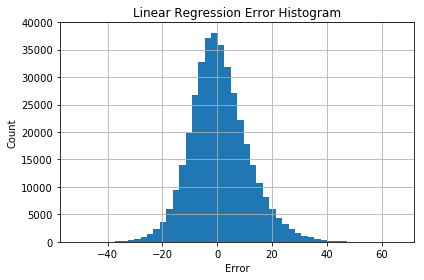

In [32]:
truth = test["age"]
errors = (predictions-truth)
mse_linear = np.mean( (errors)**2 )
mae_linear = np.mean( np.abs(errors) )
linear_25 = np.percentile( errors, 25)
linear_75 = np.percentile( errors, 75)
print ("MSE:", mse_linear)
print ("MAE:", mae_linear)
print ("25th percentile of errors:", linear_25)
print ("75th percentile of errors:", linear_75)
plt.hist((errors), bins=50)
plt.title("Linear Regression Error Histogram")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid()
plt.savefig("Linear_Error_Histogram.png")
plt.show()

In [19]:
from sklearn.linear_model import HuberRegressor

In [23]:
best_alpha = 0
best_epsilon = 0
best_error = np.Infinity
alphas = [1, 10, 100, 200, 500]
epsilons = [1.0, 1.15, 1.35, 1.6, 1.95]
grid_errors = np.zeros([len(alphas), len(epsilons)])
for a in range(len(alphas)):
    for e in range(len(epsilons)):
        print "fitting with alpha =", alphas[a], "and epsilon =", epsilons[e]
        # fit huber
        huber=HuberRegressor(alpha=alphas[a], epsilon=epsilons[e])
        huber.fit(sdat[1:int(n/4)], train["age"][1:int(n/4)])
    
        predictions = huber.predict(vdat)
        mse = np.mean((predictions - validate["age"])**2)
        
        # Save and check
        grid_errors[a,e] = mse
        if mse < best_error:
            best_alpha = alphas[a]
            best_epsilon = epsilons[e]
            best_error = mse
        
print "Best alpha is:", best_alpha
print "Best epsilon is:", best_epsilon


 fitting with alpha = 1 and epsilon = 1.0 fitting with alpha = 1 and epsilon = 1.15 fitting with alpha = 1 and epsilon = 1.35 fitting with alpha = 1 and epsilon = 1.6 fitting with alpha = 1 and epsilon = 1.95 fitting with alpha = 10 and epsilon = 1.0 fitting with alpha = 10 and epsilon = 1.15 fitting with alpha = 10 and epsilon = 1.35 fitting with alpha = 10 and epsilon = 1.6 fitting with alpha = 10 and epsilon = 1.95 fitting with alpha = 100 and epsilon = 1.0 fitting with alpha = 100 and epsilon = 1.15 fitting with alpha = 100 and epsilon = 1.35 fitting with alpha = 100 and epsilon = 1.6 fitting with alpha = 100 and epsilon = 1.95 fitting with alpha = 200 and epsilon = 1.0 fitting with alpha = 200 and epsilon = 1.15 fitting with alpha = 200 and epsilon = 1.35 fitting with alpha = 200 and epsilon = 1.6 fitting with alpha = 200 and epsilon = 1.95 fitting with alpha = 500 and epsilon = 1.0 fitting with alpha = 500 and epsilon = 1.15 fitting with alpha = 500 and epsilon = 1.35 fitting wit

In [30]:
error

109.1918202665786

In [24]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

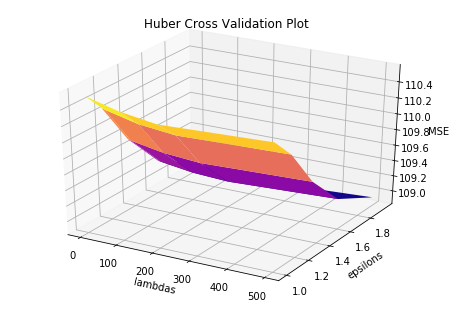

In [28]:
xs, ys = np.meshgrid(alphas, epsilons)
fig = plt.figure()
ax = Axes3D(fig)
ax.plot_surface(xs, ys, np.transpose(grid_errors), rstride=1, cstride=1, cmap='plasma')
plt.xlabel("lambdas")
plt.ylabel("epsilons")
plt.title("Huber Cross Validation Plot")
ax.set_zlabel("MSE")
#fig.tight_layout()
#fig.subplots_adjust(bottom=.025)
#plt.savefig("Huber_CV.png")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (5,) and (382231,)

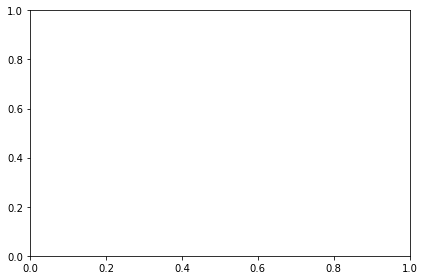

In [29]:
plt.plot(alphas, errors)
plt.xlabel("Tuning Parameter")
plt.ylabel("Validation Error")
plt.title("Tuning Parameter and CV Error")
plt.grid()
#plt.savefig("Huber_CV.png")
plt.show()

In [26]:
huber = HuberRegressor(alpha=best_alpha,epsilon=best_epsilon)
huber.fit(sdat[1:int(n/4)], train["age"][1:int(n/4)])
    
predictions = huber.predict(tdat)

('MSE:', 115.085924612083)
('MAE:', 8.214976545816606)
('25th percentile of errors:', -5.7043663137315299)
('75th percentile of errors:', 7.4785925313236206)


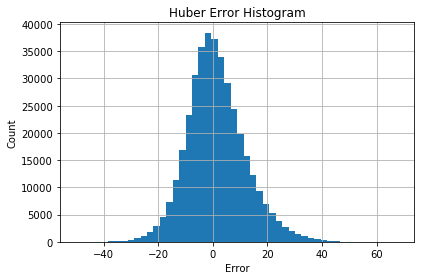

In [27]:
truth = test["age"]
errors = (predictions-truth)
mse_huber = np.mean( (errors)**2 )
mae_huber = np.mean( np.abs(errors) )
huber_25 = np.percentile( errors, 25)
huber_75 = np.percentile( errors, 75)
print ("MSE:", mse_huber)
print ("MAE:", mae_huber)
print ("25th percentile of errors:", huber_25)
print ("75th percentile of errors:", huber_75)
plt.hist((errors), bins=50)
plt.title("Huber Error Histogram")
plt.xlabel("Error")
plt.ylabel("Count")
plt.grid()
plt.savefig("Huber_Error_Histogram.png")
plt.show()

In [29]:

np.mean((huber.predict(vdat) - validate["age"])**2)

108.86557279143015